In [69]:

import os
import random
import shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [70]:

# Set seed for reproducibility

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [71]:
import kagglehub

# Download latest dataset
path = kagglehub.dataset_download("vbookshelf/rice-leaf-diseases")
print("Path to dataset files:", path)

# Dataset root folder
updated_path = os.path.join(path, 'rice_leaf_diseases')
print(os.listdir(updated_path))

# Class folders
Leaf_smut = os.path.join(updated_path, 'Leaf smut')
leaf_blight = os.path.join(updated_path, 'Bacterial leaf blight')
Brown_spot = os.path.join(updated_path, 'Brown spot')

# Check sample files
print("Leaf smut files:", os.listdir(Leaf_smut)[:5])
print("Leaf blight files:", os.listdir(leaf_blight)[:5])
print("Brown spot files:", os.listdir(Brown_spot)[:5])

Using Colab cache for faster access to the 'rice-leaf-diseases' dataset.
Path to dataset files: /kaggle/input/rice-leaf-diseases
['Brown spot', 'Bacterial leaf blight', 'Leaf smut']
Leaf smut files: ['DSC_0330.jpg', 'DSC_0313.JPG', 'DSC_0515.jpg', 'DSC_0315.jpg', 'DSC_0338.JPG']
Leaf blight files: ['DSC_0372.JPG', 'DSC_0374.JPG', 'DSC_0398.JPG', 'DSC_0396.JPG', 'DSC_0370.jpg']
Brown spot files: ['DSC_0305.JPG', 'DSC_0394.jpg', 'DSC_0105.jpg', 'DSC_0104.jpg', 'DSC_0325.JPG']


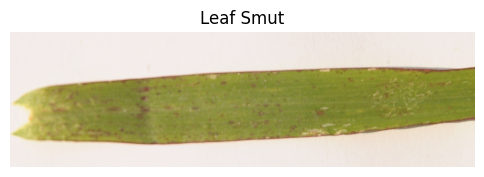

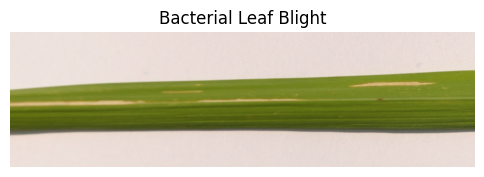

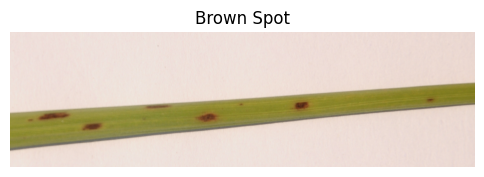

In [72]:

i = 20

Leaf_smut_1 = Image.open(os.path.join(Leaf_smut, os.listdir(Leaf_smut)[i]))
plt.figure(figsize=(6,6))
plt.imshow(Leaf_smut_1)
plt.axis('off')
plt.title("Leaf Smut")
plt.show()

leaf_blight_1 = Image.open(os.path.join(leaf_blight, os.listdir(leaf_blight)[i]))
plt.figure(figsize=(6,6))
plt.imshow(leaf_blight_1)
plt.axis('off')
plt.title("Bacterial Leaf Blight")
plt.show()

Brown_spot_1 = Image.open(os.path.join(Brown_spot, os.listdir(Brown_spot)[i]))
plt.figure(figsize=(6,6))
plt.imshow(Brown_spot_1)
plt.axis('off')
plt.title("Brown Spot")
plt.show()

In [73]:
# Split dataset into train/val/test directories

output_base = "dataset_split"

for folder in ["train", "val", "test"]:
    for cls in ["Leaf smut", "Bacterial leaf blight", "Brown spot"]:
        os.makedirs(os.path.join(output_base, folder, cls), exist_ok=True)

# Function to copy files
def split_and_copy(class_folder, class_name, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    files = os.listdir(class_folder)
    random.shuffle(files)
    n = len(files)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)

    for f in files[:n_train]:
        shutil.copy(os.path.join(class_folder, f), os.path.join(output_base, "train", class_name, f))
    for f in files[n_train:n_train+n_val]:
        shutil.copy(os.path.join(class_folder, f), os.path.join(output_base, "val", class_name, f))
    for f in files[n_train+n_val:]:
        shutil.copy(os.path.join(class_folder, f), os.path.join(output_base, "test", class_name, f))

# Split each class
split_and_copy(Leaf_smut, "Leaf smut")
split_and_copy(leaf_blight, "Bacterial leaf blight")
split_and_copy(Brown_spot, "Brown spot")


In [74]:

IMG_SIZE = (128, 128)
BATCH_SIZE = 10

In [75]:
import cv2

In [ ]:

# Training augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# Validation & test
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_base, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)

val_generator = test_val_datagen.flow_from_directory(
    os.path.join(output_base, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=seed
)

test_generator = test_val_datagen.flow_from_directory(
    os.path.join(output_base, "test"),
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


In [77]:

# Build CNN Model
def build_simple_cnn(input_shape=(128,128,3), num_classes=3, dropout_rate=0.5):
    model = models.Sequential()
    # Conv block 1
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))
    # Conv block 2
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    # Conv block 3
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    # Flatten & Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

model = build_simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=3, dropout_rate=0.5)
model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,612,867 (32.86 MB)

 Trainable params: 8,612,867 (32.86 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:

adam_epochs = 20

# First, Adam
model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_adam = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=adam_epochs
)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6967 - loss: 0.6090 - val_accuracy: 0.8788 - val_loss: 0.5140
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7399 - loss: 0.6228 - val_accuracy: 0.8182 - val_loss: 0.5205
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7445 - loss: 0.6132 - val_accuracy: 0.8182 - val_loss: 0.5156
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7929 - loss: 0.5612 - val_accuracy: 0.8788 - val_loss: 0.4996
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7742 - loss: 0.5660 - val_accuracy: 0.8788 - val_loss: 0.4964
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8349 - loss: 0.5711 - val_accuracy: 0.8788 - val_loss: 0.4914
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7640 - loss: 0.5884 - val_accuracy: 0.8485 - val_loss: 0.4839
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7935 - loss: 0.5733 - val_accuracy: 0.8788 - val_loss:

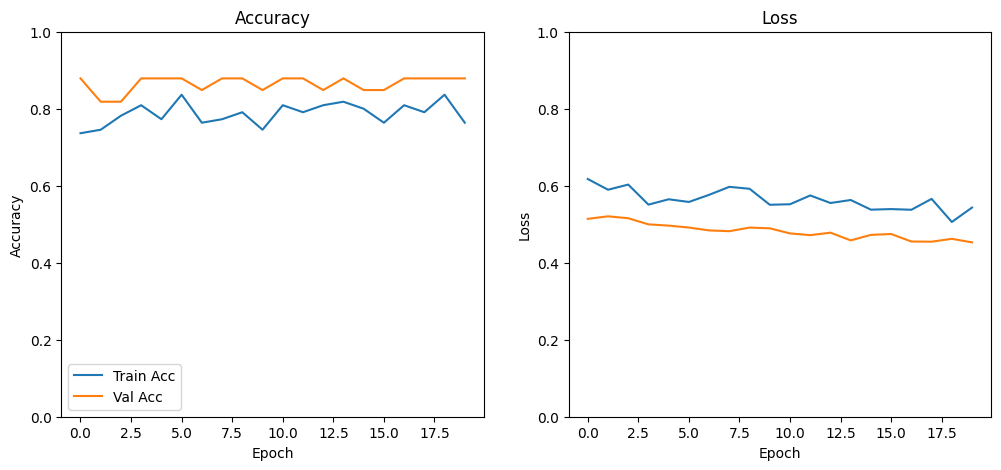

In [84]:
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_adam.history['accuracy'], label='Train Acc')
plt.plot(history_adam.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_adam.history['loss'], label='Train Loss')
plt.plot(history_adam.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 1)

plt.show()


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9136 - loss: 0.3344
Test Accuracy: 80.00%
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


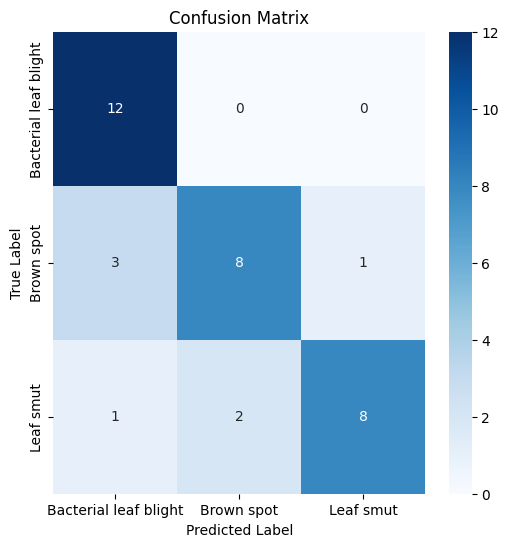

                       precision    recall  f1-score   support

Bacterial leaf blight       0.75      1.00      0.86        12
           Brown spot       0.80      0.67      0.73        12
            Leaf smut       0.89      0.73      0.80        11

             accuracy                           0.80        35
            macro avg       0.81      0.80      0.79        35
         weighted avg       0.81      0.80      0.79        35



In [85]:

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Confusion Matrix
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

In [102]:


model.compile(optimizer=optimizers.SGD(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_sgd = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=adam_epochs)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6573 - loss: 0.8420 - val_accuracy: 0.6364 - val_loss: 0.7989
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5689 - loss: 0.8762 - val_accuracy: 0.6364 - val_loss: 0.7988
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5581 - loss: 0.8803 - val_accuracy: 0.6364 - val_loss: 0.7987
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 994ms/step - accuracy: 0.6691 - loss: 0.8216 - val_accuracy: 0.6364 - val_loss: 0.7985
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1000ms/step - accuracy: 0.5992 - loss: 0.7993 - val_accuracy: 0.6364 - val_loss: 0.7984
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6638 - loss: 0.8316 - val_accuracy: 0.6364 - val_loss: 0.7982
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 908ms/step - accuracy: 0.6681 - loss: 0.8152 - val_accuracy: 0.6364 - val_loss: 0.7981
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 902ms/step - accuracy: 0.6157 - loss: 0.8602 - val_accuracy: 0.636

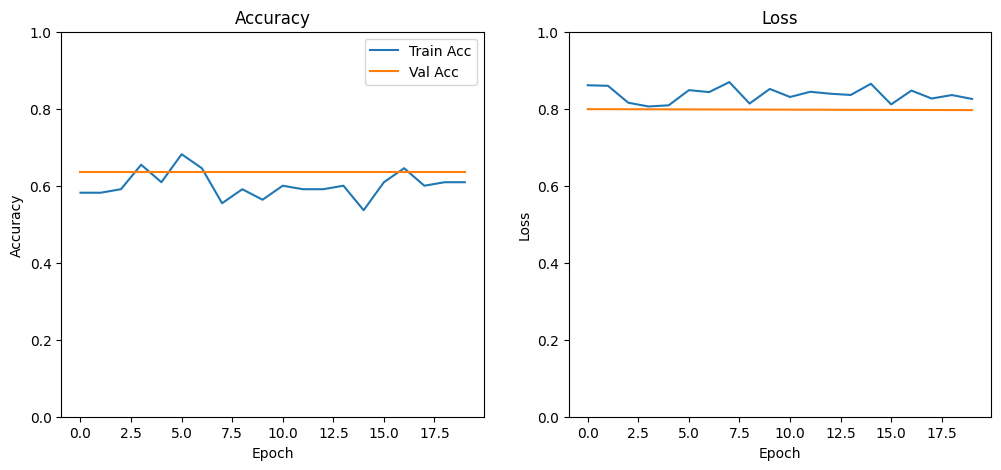

In [103]:
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_sgd.history['accuracy'], label='Train Acc')
plt.plot(history_sgd.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_sgd.history['loss'], label='Train Loss')
plt.plot(history_sgd.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 1)

plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8591 - loss: 0.5907
Test Accuracy: 71.43%
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


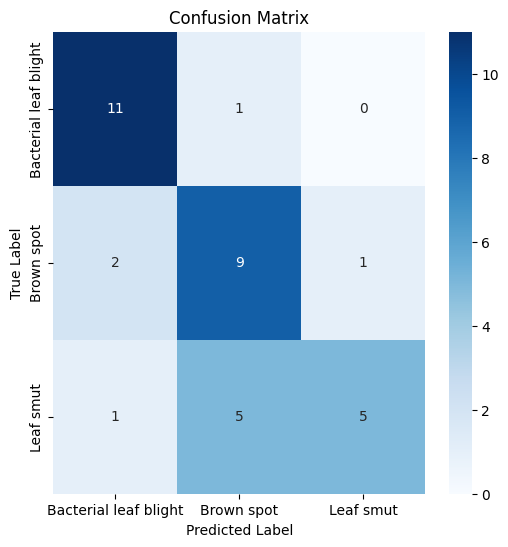

                       precision    recall  f1-score   support

Bacterial leaf blight       0.79      0.92      0.85        12
           Brown spot       0.60      0.75      0.67        12
            Leaf smut       0.83      0.45      0.59        11

             accuracy                           0.71        35
            macro avg       0.74      0.71      0.70        35
         weighted avg       0.74      0.71      0.70        35



In [104]:

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Confusion Matrix
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

In [112]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.00001, momentum=0.7),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_sgdm = model.fit(train_generator,
                         validation_data=val_generator,
                         epochs=adam_epochs)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6219 - loss: 0.8220 - val_accuracy: 0.6667 - val_loss: 0.7800
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5141 - loss: 0.8384 - val_accuracy: 0.6667 - val_loss: 0.7799
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6848 - loss: 0.7757 - val_accuracy: 0.6364 - val_loss: 0.7795
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6527 - loss: 0.7894 - val_accuracy: 0.6364 - val_loss: 0.7793
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 946ms/step - accuracy: 0.5929 - loss: 0.8242 - val_accuracy: 0.6364 - val_loss: 0.7790
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 957ms/step - accuracy: 0.6245 - loss: 0.8260 - val_accuracy: 0.6364 - val_loss: 0.7788
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6206 - loss: 0.7895 - val_accuracy: 0.6364 - val_loss: 0.7785
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6410 - loss: 0.7951 - val_accuracy: 0.6364 - val

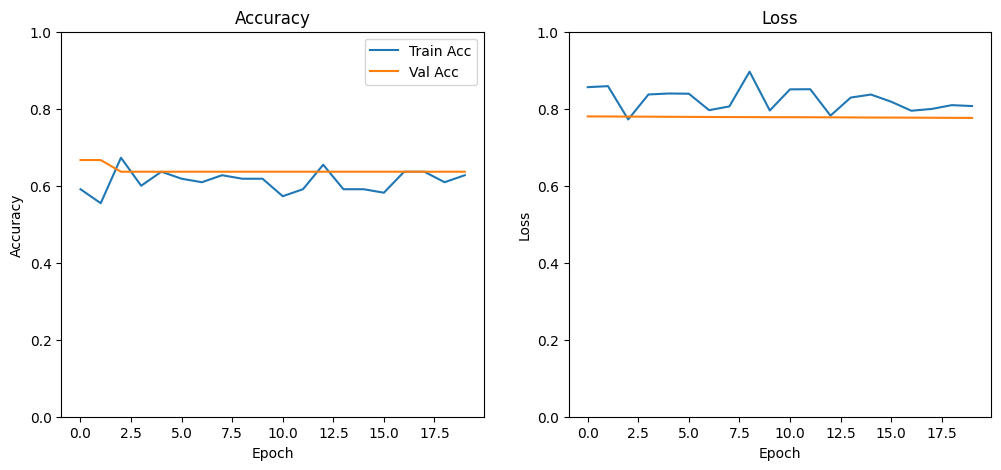

In [113]:
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_sgdm.history['accuracy'], label='Train Acc')
plt.plot(history_sgdm.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_sgdm.history['loss'], label='Train Loss')
plt.plot(history_sgdm.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 1)

plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8386 - loss: 0.5305
Test Accuracy: 68.57%
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


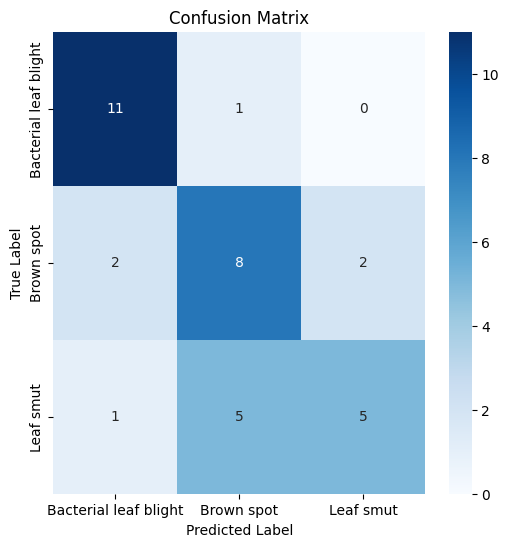

                       precision    recall  f1-score   support

Bacterial leaf blight       0.79      0.92      0.85        12
           Brown spot       0.57      0.67      0.62        12
            Leaf smut       0.71      0.45      0.56        11

             accuracy                           0.69        35
            macro avg       0.69      0.68      0.67        35
         weighted avg       0.69      0.69      0.68        35



In [114]:

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Confusion Matrix
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

In [86]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess

In [87]:
def create_data_generators(model_name, batch_size=16):
    IMG_SIZE = (224, 224)  # Standard size for pre-trained models

    if model_name == 'vgg16':
        preprocess_func = vgg_preprocess
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_func,
            rotation_range=15,
            width_shift_range=0.05,
            height_shift_range=0.05,
            zoom_range=0.1,
            horizontal_flip=True
        )
        test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)

    elif model_name == 'resnet50':
        preprocess_func = resnet_preprocess
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_func,
            rotation_range=15,
            width_shift_range=0.05,
            height_shift_range=0.05,
            zoom_range=0.1,
            horizontal_flip=True
        )
        test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        os.path.join(output_base, "train"),
        target_size=IMG_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed
    )

    val_generator = test_val_datagen.flow_from_directory(
        os.path.join(output_base, "val"),
        target_size=IMG_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed
    )

    test_generator = test_val_datagen.flow_from_directory(
        os.path.join(output_base, "test"),
        target_size=IMG_SIZE,
        batch_size=1,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator


In [88]:
# VGG16 Model
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False,
                       input_shape=(224, 224, 3))

    # Freeze base model layers initially
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')
    ])

    return model, base_model

In [89]:

# ResNet50 Model
def create_resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False,
                         input_shape=(224, 224, 3))

    # Freeze base model layers initially
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')
    ])

    return model, base_model


In [90]:

# Training function for pre-trained models
def train_pretrained_model(model_type, epochs=20, fine_tune_epochs=10):

    if model_type == 'vgg16':
        model, base_model = create_vgg16_model()
        train_gen, val_gen, test_gen = create_data_generators('vgg16')
    elif model_type == 'resnet50':
        model, base_model = create_resnet50_model()
        train_gen, val_gen, test_gen = create_data_generators('resnet50')

    # Step 1: Train only the top layers
    print(f"=== Phase 1: Training Top Layers of {model_type.upper()} ===")
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history1 = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        verbose=1
    )

    # Step 2: Fine-tune with lower learning rate
    print(f"=== Phase 2: Fine-tuning {model_type.upper()} ===")
    base_model.trainable = True

    # Fine-tune from this layer onwards
    fine_tune_at = len(base_model.layers) // 2

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001/10),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history2 = model.fit(
        train_gen,
        epochs=fine_tune_epochs,
        validation_data=val_gen,
        verbose=1
    )

   # Combine histories
    combined_history = {}
    for key in history1.history.keys():
        combined_history[key] = history1.history[key] + history2.history[key]

    return model, combined_history, test_gen



In [91]:
# Train both models
print("Training VGG16...")
vgg_model, vgg_history, vgg_test_gen = train_pretrained_model('vgg16', epochs=15, fine_tune_epochs=10)

print("\nTraining ResNet50...")
resnet_model, resnet_history, resnet_test_gen = train_pretrained_model('resnet50', epochs=15, fine_tune_epochs=10)


Training VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 110 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Found 35 images belonging to 3 classes.
=== Phase 1: Training Top Layers of VGG16 ===


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 79s 11s/step - accuracy: 0.3037 - loss: 3.4989 - val_accuracy: 0.5758 - val_loss: 1.6999
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 77s 11s/step - accuracy: 0.5627 - loss: 1.7411 - val_accuracy: 0.6970 - val_loss: 1.2043
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 11s/step - accuracy: 0.6405 - loss: 1.1929 - val_accuracy: 0.7576 - val_loss: 1.0005
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 75s 11s/step - accuracy: 0.7620 - loss: 0.8311 - val_accuracy: 0.7576 - val_loss: 0.7277
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 11s/step - accuracy: 0.8623 - loss: 0.4494 - val_accuracy: 0.7879 - val_loss: 0.6247
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 11s/step - accuracy: 0.8671 - loss: 0.3456 - val_accuracy: 0.8485 - val_loss: 0.3917
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 75s 11s/step - accuracy: 0.9549 - loss: 0.1567 - val_accuracy: 0.8788 - val_loss: 0.3099
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 11s/step - accuracy: 0.9538 - loss: 0.1437 - val_accuracy: 0.9091 - val_loss: 0.2512


In [92]:

# Plot training history for both models
def plot_comparison_history(histories, model_names):
    plt.figure(figsize=(15, 5))

    for i, metric in enumerate(['accuracy', 'loss']):
        plt.subplot(1, 2, i+1)
        for history, name in zip(histories, model_names):
            if metric in history.history:
                plt.plot(history.history[metric], label=f'{name} Train')
                plt.plot(history.history[f'val_{metric}'], label=f'{name} Val', linestyle='--')

        plt.title(f'Model {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


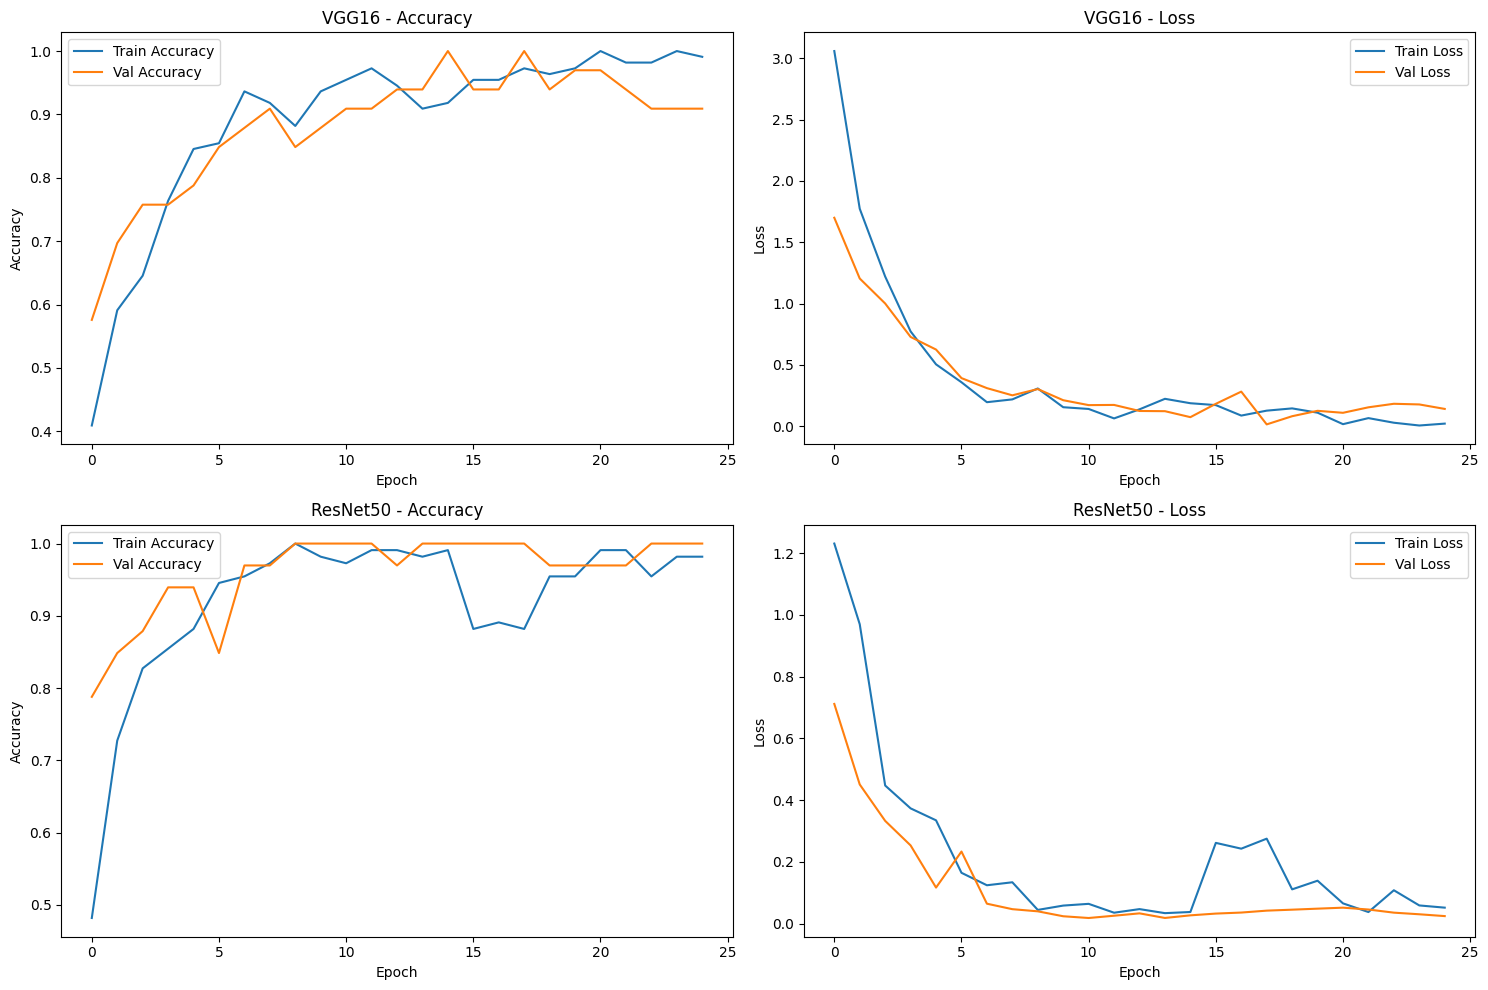

In [93]:
# Plot for pre-trained models
histories = [vgg_history, resnet_history]
model_names = ['VGG16', 'ResNet50']

plt.figure(figsize=(15, 10))
for i, (history, name) in enumerate(zip(histories, model_names)):
    plt.subplot(2, 2, i*2+1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, i*2+2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

In [94]:
def evaluate_model(model, test_generator, model_name):
    print(f"\n=== {model_name} Evaluation ===")

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    # Predictions
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = test_generator.classes

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Classification Report
    print(f"\n{classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())}")

    return test_acc, test_loss, y_pred, y_true



=== VGG16 Evaluation ===
Test Accuracy: 91.43%
Test Loss: 0.1316
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 515ms/step


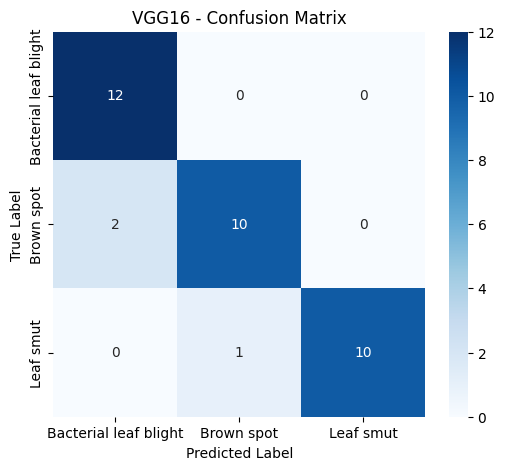


                       precision    recall  f1-score   support

Bacterial leaf blight       0.86      1.00      0.92        12
           Brown spot       0.91      0.83      0.87        12
            Leaf smut       1.00      0.91      0.95        11

             accuracy                           0.91        35
            macro avg       0.92      0.91      0.92        35
         weighted avg       0.92      0.91      0.91        35


=== ResNet50 Evaluation ===


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy: 100.00%
Test Loss: 0.0293
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step


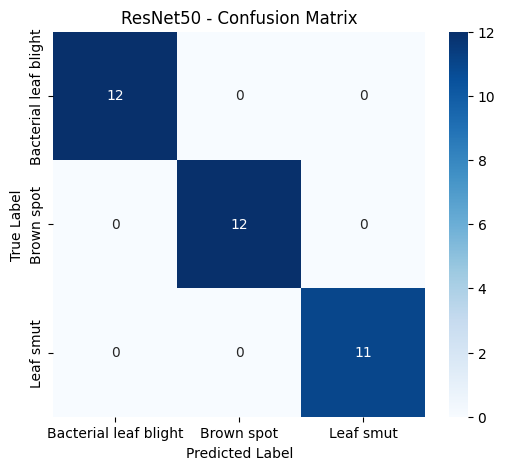


                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      1.00      1.00        12
           Brown spot       1.00      1.00      1.00        12
            Leaf smut       1.00      1.00      1.00        11

             accuracy                           1.00        35
            macro avg       1.00      1.00      1.00        35
         weighted avg       1.00      1.00      1.00        35



In [95]:

# Evaluate VGG16
vgg_acc, vgg_loss, vgg_y_pred, vgg_y_true = evaluate_model(vgg_model, vgg_test_gen, "VGG16")

# Evaluate ResNet50
resnet_acc, resnet_loss, resnet_y_pred, resnet_y_true = evaluate_model(resnet_model, resnet_test_gen, "ResNet50")